# How many samples are necessary to estimate agreement between two neural networks as a function of their parameter count

1. One definition of NN agreement is just the average difference between two NNs on all inputs. Call this $D_{true}$.
2. Estimate $D_{true}$ with a sample of size N. How many samples until $D_{true} - D_{sample} \lt \epsilon$ for some small $\epsilon$?
3. How does the number of samples depend on N, the number of parameters in the network?


Experiment:
1. For $P=\{10,100,1000\}$:
2. Take "true" $D$ as $D_{1e9}$
3. Start at $S=10$
4. For $30$ trials at $S=10$ compute variance between $D_{sample}$ and $D_{true}$ as ${1\over30}\sum{|D_{true}-D_{sample}|}$
5. If variance below $0.015$ accept $S$ as large enough sample for good estimate.
6. If variance too large increase number of samples and GOTO 4.
7. Plot number of parameters versus sufficient sample size.
8. Say something vaguely informative about the dependency between number of parameters and number of sufficient samples.


### Estimate number of samples to estimate f-distance

In [9]:
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt



N = 10
param_to_size = {}
for size in [10, 100, 1000, 5000, 10000]:  
  
  # 1. create nns 
  nn1 = tf.keras.Sequential([    
      tf.keras.layers.Dense(size, input_shape=(N,), activation='tanh',kernel_initializer='random_normal'),
      # tf.keras.layers.Dense(10, activation='tanh',kernel_initializer='random_normal'),    
      tf.keras.layers.Dense(1,activation='tanh',kernel_initializer='random_normal')
  ])
  nn2 = tf.keras.Sequential([    
      tf.keras.layers.Dense(size, input_shape=(N,), activation='tanh',kernel_initializer='random_normal'),
      # tf.keras.layers.Dense(10, activation='tanh',kernel_initializer='random_normal'),    
      tf.keras.layers.Dense(1,activation='tanh',kernel_initializer='random_normal')
  ])


  num_params = nn1.count_params()

  print("(size,num_params) ", size,num_params)

  # 2. calculate "true" D
  ds = 0.
  for _ in range(10):
    inpt = tf.random.uniform(shape=(100000,N),minval=-1.,maxval=1.)
    ds += tf.math.reduce_mean(tf.abs(nn1(inpt)-nn2(inpt))).numpy()
  D_true = ds/10.
  print("D_true: ",D_true)


 

  # 3. Increase number of samples, record best sample size
  estimated_Ds = []
  for S in (10, 20, 40, 80, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000):  
    for trial in range(30):
      if S>64000: #avoid OOM
        ds = 0.
        s = 0. # total samples
        while s*10000<S:
          inpt = tf.random.uniform(shape=(10000,N),minval=-1.,maxval=1.)
          ds += tf.math.reduce_mean(tf.abs(nn1(inpt)-nn2(inpt))).numpy()
          s+=1
        D_sample = ds/s
        estimated_Ds.append(D_sample)
        S=s*10000
      else:
        inpt = tf.random.uniform(shape=(S,N,),minval=-1.,maxval=1.)
        D_sample = tf.math.reduce_mean(tf.abs(nn1(inpt)-nn2(inpt)))
        estimated_Ds.append(D_sample.numpy())
    # Compute variance from D_true
    variance = tf.math.reduce_mean(tf.abs(D_true - tf.constant(estimated_Ds)))
    print(S,variance)

    if variance<=0.015:
      param_to_size[num_params]=S
      break



#4. Graph param_to_size
print(param_to_size)


(size,num_params)  10 121
D_true:  0.011641139443963767
10 tf.Tensor(0.0021724165, shape=(), dtype=float32)
(size,num_params)  100 1201
D_true:  0.04434277601540089
10 tf.Tensor(0.0080988705, shape=(), dtype=float32)
(size,num_params)  1000 12001
D_true:  0.14086441099643707
10 tf.Tensor(0.026470756, shape=(), dtype=float32)
20 tf.Tensor(0.023881901, shape=(), dtype=float32)
40 tf.Tensor(0.019861536, shape=(), dtype=float32)
80 tf.Tensor(0.017873464, shape=(), dtype=float32)
1000 tf.Tensor(0.01490444, shape=(), dtype=float32)
(size,num_params)  5000 60001
D_true:  0.39552541375160216
10 tf.Tensor(0.06404079, shape=(), dtype=float32)
20 tf.Tensor(0.058642227, shape=(), dtype=float32)
40 tf.Tensor(0.04897007, shape=(), dtype=float32)
80 tf.Tensor(0.043159295, shape=(), dtype=float32)
1000 tf.Tensor(0.035777654, shape=(), dtype=float32)
2000 tf.Tensor(0.03051522, shape=(), dtype=float32)
4000 tf.Tensor(0.026691388, shape=(), dtype=float32)
8000 tf.Tensor(0.023696695, shape=(), dtype=float

#Plot results and eyeball trend

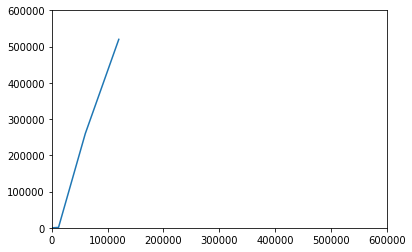

In [12]:
xs = list(param_to_size.keys())
ys = list(param_to_size.values())
plt.xlim(0,600000)
plt.ylim(0,600000)
plt.plot(xs,ys,)

It would appear that as the two networks increase in size the number of samples necessary to accurately estimate the distance between increases "exponentially". ?